# Introduction

The purpose of this script is to determine the symmetry of the Fermi surface of YbPdBi, a material which has demonstrated interesting quantum effects (which I happen to have written my thesis discussing!). A [Fermi surface](https://en.wikipedia.org/wiki/Fermi_surface) is a quantum mechanical structure that determines many of the electronic transport properties of a material (that is to say, the way electricity runs through it). For example, this surface will be different for metals, semi-conductors, and insulators. This discussion is beyond the scope of this demonstration, but free to shoot me an email if you're curious about learning about this.

In order to do this, we have taken angle-resolved magnetoresistance oscillation (AMRO) data, wherein we measure the longitudinal resistivity of a rectangular prism sample as we rotate it within a strong applied magnetic field. Resistivity is an intrinsic analogue to resistance, which you are likely more familiar with. This resistivity was measured in both positive and negative magnetic field values, and then symmetrized to minimize the influence of sample misalignment and any transverse resistivity that may be present.

We are interested in this because the symmetry of the AMRO (how many times the resistivity repeats per sample rotation), is determined by the Fermi surface. A significant change in the AMRO symmetry indicates a significant change in the Fermi surface structure. This is an unusual occurance and indicative of a significant change in the quantum physics of the material.

Investigations of such behaviour can help us discover new materials for use in technologies of the future.

In [1]:
# %matplotlib inline

#import matplotlib as mpl
import itertools
import lmfit as lm
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from matplotlib.ticker import FormatStrFormatter, MultipleLocator, AutoMinorLocator
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.optimize import curve_fit
from helper_funcs import LoadAMRO

# warnings.simplefilter(action='ignore', category=FutureWarning)
# pd.options.mode.chained_assignment = None
# working_dir = os.getcwd()

H_palette = {
    0.5: 'tab:red',
    3: 'tab:green',
    7: 'tab:orange',
    9: 'tab:blue'
}



# Load AMRO Data from Pipeline



In [2]:
# meta_data ={
#     'ACTRot11':{'geo':'perp', 'ACT':11},
#     'ACTRot12':{'geo':'para', 'ACT':12},
#     'ACTRot13':{'geo':'para', 'ACT':13},
#     'ACTRot14':{'geo':'perp', 'ACT':14}
# }

# desired_cols = [
#     'Temperature (K)', 'Sample Position (deg)', #'Magnetic Field (Oe)',
#     'Res. (ohm-cm)', 'ACT', 'ACT_str', 'T', 'H','geo' #, 'L (cm)', 'W (cm)', 'H (cm)'
# ]
# col_renames = {
#     'Res. ch2 (ohm-cm)':'Res. (ohm-cm)'
# }

# # Get names of files in the folder
# data_path = os.path.join(os.getcwd(),'Data')
# filenames = os.listdir(data_path)
# amro_df = pd.DataFrame()

# for filename in filenames:
    
#     # Ensure we are selecting only AMRO data
#     if any(key in filename for key in meta_data.keys()) and 'AMRO' in filename:

#         temp_df = pd.read_csv(os.path.join(data_path,filename), sep=',')
        
#         # Extract experimental info from filename
#         temp_name = filename.replace('.csv','').replace('0_5','0.5').replace('1p9','1.9')
#         conds = lambda x: ('ACT' in x or x.endswith('T') or x.endswith('K'))
#         for label in [a for a in temp_name.split('_') if conds(a)]:
#             if label.endswith('K'):
#                 T_label = float(label.replace('K',''))
#                 temp_df['T'] = T_label
#             elif label.endswith('T'):
#                 H_label = float(label.replace('T',''))
#                 temp_df['H'] = H_label
#             elif 'ACT' in label:
#                 act_label = label
#                 temp_df['ACT_str']= act_label
#                 temp_df['geo'] = meta_data[label]['geo']
#                 temp_df['ACT'] = meta_data[label]['ACT']
                
#                 # Update meta data 
#                 if ('L (cm)' not in meta_data[label].keys()):
#                     meta_data[label]['L (cm)'] = temp_df['L (cm)'].values[0]
#                     meta_data[label]['W (cm)'] = temp_df['W (cm)'].values[0]
#                     meta_data[label]['H (cm)'] = temp_df['H (cm)'].values[0]
          
#             else:
#                 print("Filename parsing error, fix filename for:\t"+filename)
#                 raise ValueError

#         # Create additional meta data dictionaries
#         meta_data[act_label]['T_vals'] = []
#         meta_data[act_label]['H_vals'] = []
#         meta_data[act_label][H_label] = {}
#         meta_data[act_label][H_label][T_label] = {}
        
#         # Select desired columns, rename as needed
#         temp_df = temp_df.rename(columns=col_renames)[desired_cols]
        
#         # Calc for additional columns as neededme
#         mean_res = temp_df['Res. (ohm-cm)'].mean()
#         zero_deg_res= temp_df.loc[temp_df['Sample Position (deg)'].idxmin(), 'Res. (ohm-cm)']

#         # Store additional meta data
#         this_meta_data = meta_data[act_label][H_label][T_label]
#         this_meta_data['mean res (ohm-cm)'] = mean_res
#         this_meta_data['0deg res (ohm-cm)'] = zero_deg_res

#         # Calc additional columns
#         temp_df['Delta Res. Mean (ohm-cm)'] =  temp_df['Res. (ohm-cm)'] - mean_res
#         temp_df['Delta Res./R0 Mean (ohm-cm)'] =  temp_df['Delta Res. Mean (ohm-cm)'] / mean_res
#         temp_df['Delta Res./R0 Mean (%)'] =  temp_df['Delta Res. Mean (ohm-cm)']*100

#         temp_df['Delta Res. 0deg (ohm-cm)'] = temp_df['Res. (ohm-cm)'] - zero_deg_res
#         temp_df['Delta Res./R0 0deg (ohm-cm)'] =  temp_df['Delta Res. 0deg (ohm-cm)'] / zero_deg_res
#         temp_df['Delta Res./R0 0deg (%)'] =  temp_df['Delta Res. 0deg (ohm-cm)']*100

        
#         # Alternative units
#         temp_df['Sample Position (rads)'] = temp_df['Sample Position (deg)']*2*np.pi/360
#         for col in temp_df.columns:
#             if 'Res' in col:
#                 new_col = col.replace('ohm','uohm')
#                 temp_df[new_col] = temp_df[col]*10**6
           
#         amro_df = pd.concat([amro_df, temp_df], ignore_index=True)



# # Create meta_data lists for any iteration purposes
# act_labels = amro_df['ACT_str'].unique()
# for act in act_labels:
#     act_df = amro_df.query('ACT_str=="{}"'.format(act))
#     meta_data[act]['T_vals'] = act_df['T'].unique()
#     meta_data[act]['H_vals'] = act_df['H'].unique()

# g = sns.relplot(
#     x='Sample Position (deg)',
#     y='Delta Res. Mean (uohm-cm)',
#     data=amro_df,
#     hue='T',
#     col='H',
#     row='ACT_str',
#     kind='line',
#     # linewidth=0,
#     facet_kws={'sharey':False}
# )

# # Save the long AMRO dataframe
# amro_df.to_csv('AMRO_combined_data.csv', sep=',')

load_amro = LoadAMRO('AMRO_combined_data.csv', 'Data')
amro_df = load_amro.getAMRO()

Combining AMRO files into: AMRO_combined_data.csv
11 0.5 10.0


KeyError: '11'

In [ ]:
# meta_data

# Fourier Transform

In order to determine good initial guesses for the sinusoidal fitting, we Fourier transform this data. When I first did this, it was not common procedure to do so. However, in the time between then and now, it has appeared in multiple published papers. A nice case of parallel discovery of a good idea.

The advantage to using a Fourier transform for this analysis is that the results of a Fourier transform do not depend on the choice of fitting function. This reduces the influence of personal biases, and also improves the comparability of results between AMRO-based research publications. One downside is the difficulty in determining our measurement uncertainties, an important part of science. This is why we later fit the data with sinusoids.

Each wave created by the resistivity as the sample is rotated can be deconstructed into a sum of sinusoidal waves. We are interested in the strengths of these oscillations, as we can garner information about the Fermi surface structure.


In [135]:


n = 10  # n-many strongest frequencies
force_pos_phase = True
max_sym = 10  # Frequency cut-off to ignore some noise.

# Get the unique labels for querying later
experiment_labels = amro_df[['ACT', 'T', 'H']].drop_duplicates()

# Iterate through DataFrame entries, appending results to a new DataFrame
FT_results_df = pd.DataFrame()

# for i in range(len(experiment_labels)):
for act_label in meta_data.keys():
    print(act_label)
    act_meta_data = meta_data[act_label]
    try:
        t_vals = act_meta_data['T_vals']
        h_vals = act_meta_data['H_vals']
        geo_label = act_meta_data['geo']
        
        for t, h in itertools.product(t_vals, h_vals):
    
            # Query the correct dataframe using the experiment labels
            ft_df=amro_df.query('ACT_str=="{}" & T =={} & H == {}'.format(act_label, t, h))  # 'ACT_str=="{}"'.format(act_label))  # 
    
            # label = act_label+", "+str(t)+"K, "+str(h)+"T"
    
            # To FT, we want the oscillation zero'd along the y-axis
            fftdata = ft_df['Delta Res. Mean (ohm-cm)'].values
    
            # Perform the FFT, where yf is the amplitudes and xf are the frequencies
            yf = rfft(fftdata, n= len(fftdata), norm='ortho')
            xf = rfftfreq(len(fftdata), 1/len(fftdata))
    
            # Package the results
            freq_df = pd.DataFrame({'freqs (cycles/rot)':xf,
                                    'amps':yf,
                                    'mag (ohm-cm)':np.abs(yf),
                                    'phase':np.angle(yf)
                                   })
            # freq_df.sort_values(by='mag (ohm-cm)', ascending=False, inplace=True)
            # Amplitudes relative to the strongest
            freq_df['amp_ratio'] = freq_df['mag (ohm-cm)']/freq_df['mag (ohm-cm)'].max()
            freq_df['freqs (cycles/rot)'] = freq_df['freqs (cycles/rot)'].astype(int)
            # Force positive phase values
            if force_pos_phase:
                freq_df['phase'] = np.select(
                    freq_df['phase']<0,
                    freq_df['phase']+2*np.pi,
                    freq_df['phase']
                )
            
            # freq_df = freq_df.reset_index(drop=True)
            
            # Add additional labelling information
            freq_df['ACT_str'] = act_label 
            freq_df['ACT'] = float(act_label.replace("ACTRot",""))
            freq_df['T'] = t 
            freq_df['H'] = h 
            freq_df['geo'] = geo_label 
    
            # Truncate to get the desired number of frequencies
            freq_df = freq_df.query("`freqs (cycles/rot)`<{}".format(max_sym))
            # freq_df = freq_df.reset_index(drop=True)
            strongest_freqs =  freq_df.sort_values(by='mag (ohm-cm)', ascending=False).head(n)
    
    
    
            # FT_output = FFTAMROPlot(ft_df, n=10) # Want n strongest amplitudes
            
            FT_results_df = pd.concat([FT_results_df, strongest_freqs], ignore_index=True)#.reset_index(drop=True)
    except KeyError as e:
        print('No data for: '+act_label+'. Skipping...')
        
# Save the results of the FT
FT_results_df.to_csv('AMRO_fourier_transform_results.csv', sep=',',index=False)



ACTRot11
ACTRot12
ACTRot13
No data for: ACTRot13. Skipping...
ACTRot14
No data for: ACTRot14. Skipping...


In [136]:
FT_results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype     
---  ------              --------------  -----     
 0   freqs (cycles/rot)  400 non-null    int32     
 1   amps                400 non-null    complex128
 2   mag (ohm-cm)        400 non-null    float64   
 3   phase               400 non-null    float64   
 4   amp_ratio           400 non-null    float64   
 5   ACT_str             400 non-null    object    
 6   ACT                 400 non-null    float64   
 7   T                   400 non-null    float64   
 8   H                   400 non-null    float64   
 9   geo                 400 non-null    object    
dtypes: complex128(1), float64(6), int32(1), object(2)
memory usage: 32.9+ KB


## Check by Plotting

For both orientations, it is clear that at low temperature (T), the dominant frequency shifts from 2-fold to 4-fold as the magnetic field (H) is strengthened. At higher T, this shift does not happen.
Additional symmetries appear to be present at high field and low temperature, such as 6-fold and 8-fold.


This was previously determined to be the case by inspection of the raw data.

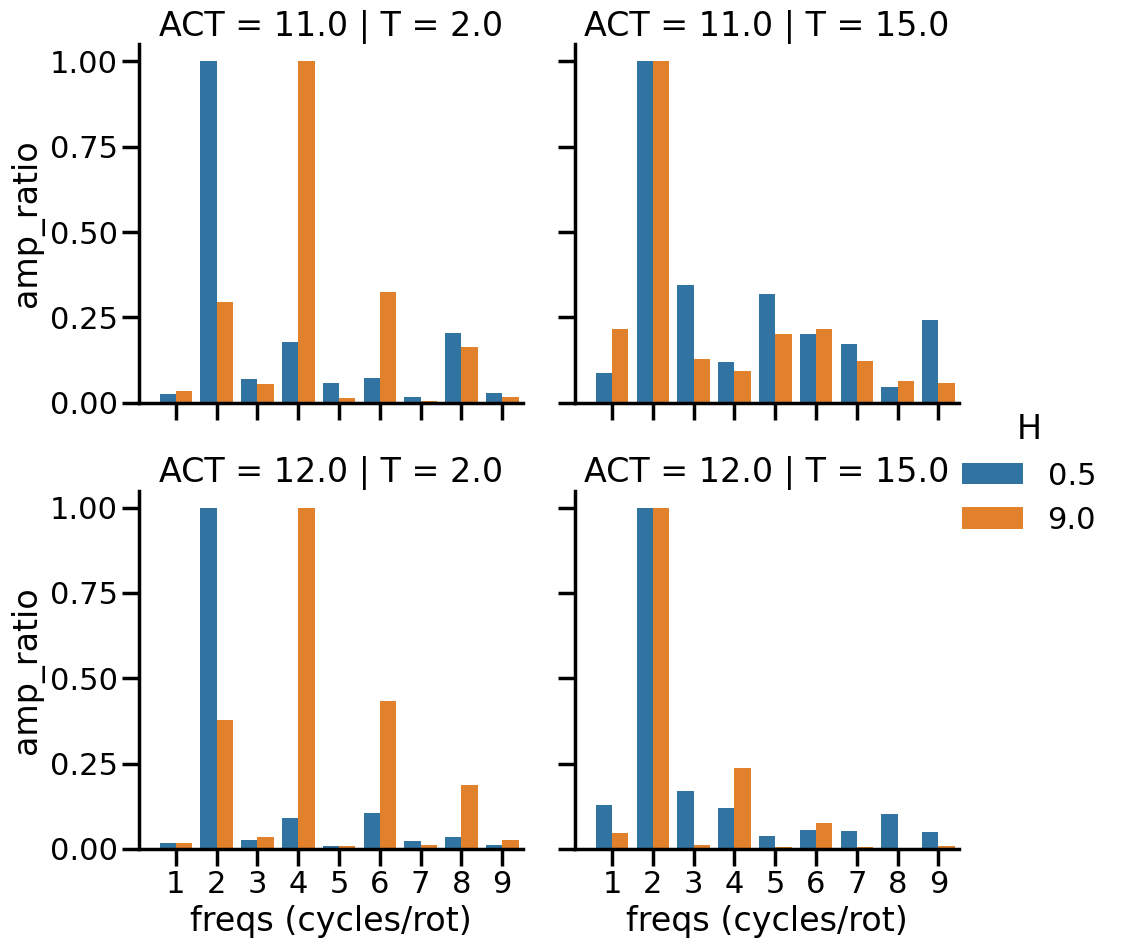

In [138]:

q = 'T in (2, 15) & H in (0.5, 9)'
plot_df = FT_results_df.query(q)

# Bypass a formatting bug in catplot
hue_choice = 'H'
plot_df = plot_df.sort_values(hue_choice)
plot_df[hue_choice] = plot_df[hue_choice].astype(str)
sns.set_context('poster')
g = sns.catplot(
    x='freqs (cycles/rot)',
    y='amp_ratio',
    data=plot_df,
    col='T',
    row='ACT',    
    kind='bar',
    hue=hue_choice,
    facet_kws={
        "sharex":False
    }
)
g.set(xlim=(0.1,None))

# Sinusoidal Fits

We can now fit the data with sinusoidal functions. This will give us a statistical uncertainty on our results.


## Fitting Function
Our choice of fitting function, which can differ betwen lab groups and papers:

$\rho_{xx}(\theta) = \rho_0\left(1 + \sum_i a_i\sin(f_i\theta+\phi_i)\right)$

An alternative function from Suzuki et al.:

$\rho_{xx}(\theta) = \rho_0 + \rho_1\sin^2(\theta)+\rho_x\cos^4(\theta)$

3.7358081077629564


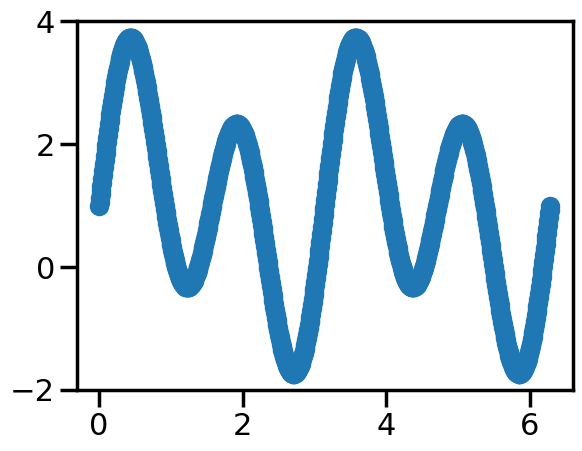

In [149]:
# Use a cosine function because we are oscillating about the mean resistivity, which will be above the deg = 0 resistivity
def SineBuilder(rads, amps_list : list, freq_list : list, phase: list, mean):
    # Want this to be as fast as possible,
    # because it will be called a lot during the curve_fit regression
    # Make these amplitudes be as a fraction of the mean
    summation = 0
    for amp, f, p in zip(amps_list, freq_list, phase):
        # res += amp*np.cos(f*rads+ p)# cos(rads, amp, f, phase)
        summation += amp*np.sin(f*rads+ p)# cos(rads, amp, f, phase)
        # res += amp*np.sin(rads+ p)**f# cos(rads, amp, f, phase)
    return mean * summation + mean


# Test function
f = [4, 2]
amp = [2, 1]
phase = [0,0]
offset = 1 

x = np.linspace(0,2*np.pi, 1000)
y = SineBuilder(x, amp, f, phase, offset)

print(max(y))
plt.scatter(x, y)

## Define Objective Function to Minimize

We will fit this function by minimizing an objective function.

In [ ]:
def ObjFcn(params, deg, res_data):
    
    amps_list = []
    freqs_list = []
    phase_list = []
    
    for key in params.keys():
        if 'amp' in key:
            amps_list.append(params[key].value)
        elif 'freq' in key:
            freqs_list.append(params[key].value)
        elif 'phase' in key:
            phase_list.append(params[key].value)

    offset = params['mean']
    
    res_model = CosineBuilder(deg, amps_list, freqs_list, phase_list, offset)

    # Want to minimize least squares
    return (res_model-res_data)**2


## Perform the Fits

In [ ]:
# Limit the fit symmetries to use
FIT_SYMMETRIES = [2, 4, 6, 8]  # [2,4, 8]  # [2, 4, 6]  #  

In [ ]:
def FitAMROData(data_df, guesses_df, f_list, ACT, H, T,
                print_results = True, plot_results = True, savefig=False, plot_residuals = False):
    # raise
    sns.set_context("paper")# rc={"axes.labelsize":20}
    # Select the experimental data to be fitted
    fit_df = data_df.query('ACT == "{}" & H == {} & T== {}'.format(ACT, H, T))
    guess_df = guesses_df.query('ACT == "{}" & H == {} & T== {}'.format(ACT, H, T))
    
    
    # Query initial values from FT_guesses using frequencies list
    freq_query = ""
    for f in f_list:
        freq_query += '`freqs (cycles/rot)` == {} '.format(f)
    freq_query = freq_query.replace(' `', '|`')  # Add OR operators between query terms
    guess_df = guess_df.query(freq_query)
    
    # raise
    # Extract data we are going to fit
    x = fit_df['Sample Position (rads)']
    y = fit_df['Res. ch2 (ohm-cm)']

    # Generate a Parameters ordered dictionary, to which we add Parameter objects
    initial_p_guesses = lm.Parameters()  

    # Calculate mean with which we can prepare the amplitudes for the cosine builder function
    y_mean = y.mean()
    
    # Append all Parameter objects, except for the last one (must deal with appended 2)
    i=0
    while i < (len(f_list)-1):  # Extra 2 will always be at the end of f_list
        freq = int(f_list[i])
        temp_df = guess_df.query('`freqs (cycles/rot)` == {}'.format(freq))
        initial_p_guesses.add('amp'+str(freq),
                             value = temp_df['mag (ohm-cm)'].values[0]/y_mean,
                            min=0)  # Forcing all amplitudes to be positive, negative values show up as a pi-large phase offset. absolute value

        initial_p_guesses.add('freq'+str(freq),
                            value = temp_df['freqs (cycles/rot)'].values[0],
                            vary=False)

        initial_p_guesses.add('phase'+str(freq),
                              value = temp_df['phase'].values[0],
                              min = -2*np.pi,
                              max=2*np.pi)
        i+=1
    
    # Deal with the final element
    if len(f_list)==len(guess_df): 
        # print('EQUAL')
        
        # If nothing has been appended, just add the information for the final FT guess
        freq = int(f_list[i])
        temp_df = guess_df.query('`freqs (cycles/rot)` == {}'.format(freq))
        # print(guess_df)
        #amp_frac = 0.1  # Fraction of strongest FT guess amplitude
        
        # Create last Parameter object
        initial_p_guesses.add('amp'+str(freq),
                            value = temp_df['mag (ohm-cm)'].values[0]/y_mean,
                            min=0)  # Forcing all amplitudes to be positive, negative values show up as a pi-large phase offset. absolute value

        initial_p_guesses.add('freq'+str(freq),
                            value = temp_df['freqs (cycles/rot)'].values[0],
                            vary=False)

        initial_p_guesses.add('phase'+str(freq),
                            value = temp_df['phase'].values[0],
                            min =  -2*np.pi, 
                              max=2*np.pi) 
    else:
        raise print('UNEQUAL')
#         print('UNEQUAL')
        # print(f_list)

        # Deal with the appended 2 and/or 4
        num_appended_f = len(f_list) - len(guess_df)

        appended_freqs = f_list[-num_appended_f:]     
        print('appended freqs:', appended_freqs)
        
        # We'll assume that if 2 wasn't detected by the FT transform,then we can
        # definitely/maybe/hopefully use the initial guesses for the strongest frequencies
        freq = 2
        temp_df = guess_df.query('amp_ratio == 1')#.format())
        amp_frac = 0.3  # Fraction of strongest FT guess amplitude
        
        for f in appended_freqs:
            # Create last Parameter object
            initial_p_guesses.add('amp'+str(int(f)),
                                value=temp_df['mag (ohm-cm)'].values[0]/y_mean*amp_frac,
                                min=0)  # Forcing all amplitudes to be positive, negative values show up as a pi-large phase offset. absolute value

            initial_p_guesses.add('freq'+str(int(f)),
                                value=temp_df['freqs (cycles/rot)'].values[0],
                                vary=False)

            initial_p_guesses.add('phase'+str(int(f)),
                                value=temp_df['phase'].values[0],
                                min=-2*np.pi, 
                                  max=2*np.pi) 


    #print(initial_p_guesses.pretty_print())
    initial_p_guesses.add('mean', value = y_mean)
    
#     x = x[~x.isna()]
#     y = y[~y.isna()]
    # Perform the minimization
    minner = lm.Minimizer(ObjFcn, initial_p_guesses, fcn_args=(x, y))
    kws  = {'options': {'maxiter':5000}}
    
    #try:
    results = minner.minimize()
    # except ValueError as e:
    #     print('Value Error')
    #     print('x', x[x.isna()])
    #     print('y', y[x.isna()])
    if print_results : print(lm.fit_report(results))
    
#     if plot_residuals:
        
#         fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
#         PlotFitOverData(fit_df, results.params, title='Best Fit Results', ax=ax1)
#         ax2.scatter(x, results.residual)
#         #ax2.set_yscale('log')
#         ax2.axhline(0)
        
#         # Formatting
#         fig.set_size_inches(10,10)
#         title = '{} Best Fit, H={}T, T={}K, f\'s='.format(ACT, H, T)#
#         for f in f_list:
#             title +=  str(int(f)) + ', '
#         title = title[:-2]

#         fig.suptitle(title, fontsize=30)  
#         plt.tight_layout()
        
#     elif not plot_residuals:
#         # Plot fitted parameters next to guessed parameters
#         fig, (ax1, ax2) = plt.subplots(1,2)
#         PlotFitOverData(fit_df, initial_p_guesses, title='Initial Guesses', ax=ax1)
#         PlotFitOverData(fit_df, results.params, title='Best Fit Results', ax=ax2)

#         # Formatting
#         fig.set_size_inches(15,5)
#         title = '{} Best Fit, H={}T, T={}K, f\'s='.format(ACT, H, T)#
#         for f in f_list:
#             title +=  str(int(f)) + ', '
#         title = title[:-2]

#         fig.suptitle(title, fontsize=30)  
#         plt.tight_layout()
    

        # Deal with figure based on input parameters
    # if savefig : 
    #     outdir='./AMRO Best Fit Plots/{} Best Fits/'.format(ACT_label)
    #     if not os.path.exists(outdir):
    #         os.mkdir(outdir)
    #     fig_file_name = outdir+title.replace('=',' ').replace(".","_").replace("\'s","").replace(',','').replace(" ","_")+".pdf"
    #     fig.savefig(fig_file_name, dpi=300, transparent=False, bbox_inches='tight')
    #     #print(ACT,H,T,'Best Fit Fig Saved')
    # if plot_results: 
    #     plt.show()
    # else:
    #     plt.close(fig)
    # print(results.params)
    # raise

    return results




In [ ]:
def FitACTExperiments(label, f_rank_min, f_ratio_min_ratio, f_max, show_fig = False): #(label, all_fits_df, f, show_fig=False):
    all_fits_df = pd.DataFrame()
    all_results_dict = {}
    # fitted_amps = pd.DataFrame()
    i=0
    for T_label, H_label in ACT_choices[label]: 
        
        # Maybe select the frequencies based on their rank and ratio wrt strongest frequency
        #q ='ACT == "{}" & H == {} & T == {} & amp_ratio >= {} & rank <= {} & `freqs (cycles/rot)`<={}'.format(label, H_label, T_label, f_ratio_min_ratio, f_rank_min, f_max)
        # q ='ACT == "{}" & H == {} & T == {} & `freqs (cycles/rot)`in (2,4,6,8)'.format(label, H_label, T_label)
        q ='ACT == "{}" & H == {} & T == {} & `freqs (cycles/rot)`in @FIT_SYMMETRIES'.format(label, H_label, T_label)

        f_info = FT_results.query(q)[['freqs (cycles/rot)',  'amp_ratio']]  # 'rank', 'amp_ratio']]
        f = f_info['freqs (cycles/rot)'].values
        print("F LIST:", f)
        # print(f)
        # raise
#         # We always want to fit f=2 and f=4
        if 2 not in f: 
            print('{}, T = {}, H = {}'.format(label, T_label, H_label))
            print("2 not in f.")
            # f =  np.append(f, 2)
            
#             print('\n**** 2-fold FT guess not present!!! ****')
#             print('{}, T = {}, H = {}'.format(label, T_label, H_label))
#             print("Appending 2... ")
            
        if 4 not in f:
            print('{}, T = {}, H = {}'.format(label, T_label, H_label))
            print("4 not in f.")
#             f = np.append(f, 4)
        
#             print('\n**** 4-fold FT guess not present!!! ****')
#             print('{}, T = {}, H = {}'.format(label, T_label, H_label))
#             print("Appending 4... ")

        results_obj = FitAMROData(amro_df, FT_results,
                                  f, label, H_label, T_label,
                                  print_results = False,
                                  plot_results = show_fig,
                                  savefig=True)

        # Pack results to add to a larger dataframe
        var_names = results_obj.var_names
        param_results = results_obj.params
        
        # Store fitted values in a dictionary, which will be turned into a dataframe and concatenated to ACT's data
        results_dict = {}
        
        f_info['act'] =  label
        f_info['T (K)'] = T_label
        f_info['H (T)'] =  H_label
        f_info['f_list'] = f

        if i == 0: 
            fitted_amps = f_info
            i+=1
        else:
            fitted_amps = pd.concat([fitted_amps, f_info])
        # Add variables to
        # i = 0
        # while i < len(var_names):
        # print(var_names)
        for var in var_names:
            results_dict[var] = param_results[var].value
            results_dict[var + " err"] = param_results[var].stderr
            # i+=1

        results_dict['ACT'] = label
        results_dict['H'] = H_label
        results_dict['T'] = T_label
        results_dict['chi squared'] = results_obj.redchi

        # Add to the larger dataframe
        results_df = pd.DataFrame(results_dict, index=[0])
        all_fits_df = pd.concat([all_fits_df, results_df], ignore_index=True)
        all_results_dict[label+"T"+str(T_label)+"H"+str(H_label)] = results_obj
        
    # replace all NaNs as zeros, assuming the problem was a mismatch between requested frequencies and FT guesses for the given experiment
    all_fits_df = all_fits_df.fillna(0)
    


    return all_fits_df, all_results_dict, fitted_amps

### Get initial gueses for ACTRot11

In [ ]:
FT_ACT_select = "ACTRot11"
max_rank =  5 # Must be at least this rank or higher (i.e. smaller than this number)
min_ratio = 0.2  # freq amplitude from FT must be at least this percentage of the strongest freq

freq_check_df = pd.DataFrame() # NEED THIS for groupby code

dominant_freqs = FT_results.query('amp_ratio >= {} & ACT =="{}"'.format(min_ratio, FT_ACT_select))[[ 'freqs (cycles/rot)', 'amp_ratio']]  # FT_results.query('rank <={} & amp_ratio >= {} & ACT =="{}"'.format(max_rank, min_ratio, FT_ACT_select))[[ 'freqs (cycles/rot)', 'amp_ratio']]

# freq_check_groupby = dominant_freqs.groupby(['T', 'H', 'freqs (cycles/rot)']).count()
freq_check_df['f']= dominant_freqs.groupby(['freqs (cycles/rot)']).groups
freq_check_df.set_index('f', inplace=True)

freq_check_df['count']= dominant_freqs.groupby('freqs (cycles/rot)').count().values
freq_check_df['sum']= dominant_freqs.groupby( 'freqs (cycles/rot)').sum().values
freq_check_df['mean']= dominant_freqs.groupby('freqs (cycles/rot)').mean().values
freq_check_df = freq_check_df.sort_values('sum', ascending=False)

print(FT_ACT_select)
print(freq_check_df)


### Fit ACTRot11

In [ ]:
ACT_label = 'ACTRot11'

min_f_rank = max_rank   # Must be this rank or higher (i.e. smaller than this number)
min_f_ratio = min_ratio # Amplitude must be at this fraction or more of the strongest FT guess
max_freq =  14 # 16           # Use to avoid fitting noise

ACTRot11_params_df, ACTRot11_results_dict, fitted_amps_11_df = FitACTExperiments(ACT_label, min_f_rank, min_f_ratio, f_max=max_freq, show_fig = False)


ACTRot11_params_df['geo'] = 'perp'
ACTRot11_params_df.to_csv("Best Fit Results" + ACT_label + ".csv", sep=',')

print('NaN Check:', ACTRot11_params_df.isnull().values.any())
# print(fitted_amps_dict)

## Check the Fit Results

In [ ]:
# Add additional columns as needed